In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
#Coéfficients physiques
K=.5 #coefficient diffusion
b=.2 # dtC=-b*rho*C
F0= 1 # dtRho = Fo*Mu

physique = [K,b,F0]

#Paramêtres numériques 
n_t=1001 #nombre de pas de temps
tf=20 # temps final de la simulation
xf = 150 #longeur de la simulation
n_x = 40 #nombres de points de la simulation
yf = xf
n_y = n_x 
n_xy = n_x * n_y
numerique = [n_t,tf,xf,n_x,yf,n_y]

params = physique,numerique
#Données initiales 
XY = np.zeros(n_xy)

rho0=np.zeros(n_xy) #rho initial	
mu0=np.zeros(n_xy)#mu initial
mu0[((n_xy+n_x)//2):((n_xy+n_x)//2)+1]=.01
c0=np.zeros(n_xy)+1 #concentration initiale

In [3]:
class EDP():
    def __init__(self,params):
        self.physique, self.numerique = params
        self.K,self.b,self.F0 = self.physique
        self.n_t,self.tf,self.xf,self.n_x,self.yf,self.n_y = self.numerique
        
        
        self.n_xy = self.n_x*self.n_y
        self.dt = self.tf/(self.n_t-1)
        self.dx = self.xf/(self.n_x-1)
        self.dy = self.yf/(self.n_y-1)
        
        self.X = np.linspace(0,self.xf,self.n_x)
        self.Y = np.linspace(0,self.yf,self.n_y)
        self.T = np.linspace(0,self.tf,self.n_t)
        self.rho0 = np.zeros(self.n_xy)
        self.mu0 = np.zeros(self.n_xy)
        self.c0 = np.zeros(self.n_xy)
        
        #Matrice du Laplacien
        Lapl = np.zeros((self.n_xy,self.n_xy))
        Lapl += np.diag(-4*np.ones(n_xy),0)
        Lapl += np.diag(np.ones(n_xy-1),1)+np.diag(np.ones(n_xy-1),-1)
        Lapl += np.diag(np.ones(n_xy-n_y),n_y)+np.diag(np.ones(n_xy-n_y),-n_y)
        self.Lapl = sp.csr_matrix(Lapl)
        self.Lapl *= -self.K*self.dt/(self.dx**2)
        
    def array_to_2D(n_x,vect):
        return np.array(np.split(vect,n_x))

    def integrate(self,initial):
        initial = mu,rho,c
        alpha=-c*self.dt*(1+self.dt*self.F0)+self.dt*rho+1
        A = self.Lapl + sp.diags(alpha,0)
        Target =  mu+self.dt*c*rho
        
        next_mu = spsolve(A,Target)
        next_rho = rho + self.dt*self.F0*next_mu
        next_c = c/(1+self.b*self.dt*next_rho)
        return next_mu, next_rho, next_c

In [4]:
Agent = EDP(params)

mu= mu0
rho= rho0
c= c0
Mu=[mu0]
Rho=[rho0]
C=[c0]
n = 0

while n<n_t:
    next_mu,next_rho,next_c = Agent.integrate((mu,rho,c)) 
    Mu.append(mu)
    Rho.append(rho)
    C.append(c)
    n+=1
    mu,rho,c= next_mu,next_rho,next_c

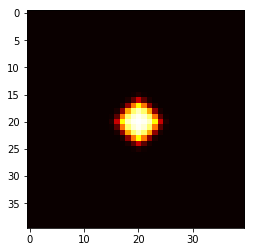

In [5]:
plt.imshow(EDP.array_to_2D(n_x,Rho[500]), cmap='hot')
plt.show()

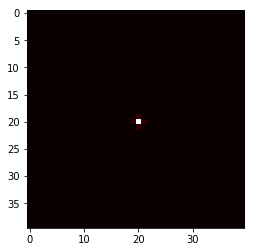

In [6]:
fig = plt.figure() 
im = plt.imshow(EDP.array_to_2D(n_x,Rho[50]),cmap='hot', animated=True)
i = 50
def updatefig(*args):
    global i
    i+=20
    if i< n_t -1:
        im.set_array(EDP.array_to_2D(n_x,Rho[i]))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [7]:
HTML(ani.to_jshtml())